In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:

X=loadmat('../input/pavia-university-hsi/PaviaU.mat')['paviaU']
y=loadmat('../input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']
    

In [3]:
dataset='PU'
test_ratio=0.7
pixelsize=25

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
X.shape, y.shape

((610, 340, 103), (610, 340))

In [9]:
K=X.shape[2]
K

103

In [10]:
X,pca=applyPCA(X,numComponents=15)
X.shape

(610, 340, 15)

In [11]:
X, y = createImageCubes(X, y, windowSize=25)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 25, 25, 15), (29944, 25, 25, 15), (12832,), (29944,))

In [13]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((8555, 25, 25, 15), (4277, 25, 25, 15), (8555,), (4277,))

In [14]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
Xtrain.shape

(8555, 25, 25, 15, 1)

In [15]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(8555, 9)

In [16]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
Xvalid.shape

(4277, 25, 25, 15, 1)

In [17]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(4277, 9)

In [18]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=9, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


In [19]:
model=Model(inputs=input_layer,outputs=output_layer)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [21]:
adam=Adam(learning_rate=0.001,decay=1e-06)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

In [23]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=10,callbacks=callback_list)

Epoch 1/10
34/34 [==============================] - 31s 890ms/step - loss: 1.1781 - accuracy: 0.5915 - val_loss: 0.4147 - val_accuracy: 0.8698
Epoch 2/10
34/34 [==============================] - 30s 876ms/step - loss: 0.2698 - accuracy: 0.9063 - val_loss: 0.0711 - val_accuracy: 0.9825
Epoch 3/10
34/34 [==============================] - 30s 876ms/step - loss: 0.0785 - accuracy: 0.9745 - val_loss: 0.0320 - val_accuracy: 0.9918
Epoch 4/10
34/34 [==============================] - 29s 851ms/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.0107 - val_accuracy: 0.9960
Epoch 5/10
34/34 [==============================] - 29s 865ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.0150 - val_accuracy: 0.9970
Epoch 6/10
34/34 [==============================] - 29s 869ms/step - loss: 0.0086 - accuracy: 0.9970 - val_loss: 0.0212 - val_accuracy: 0.9965
Epoch 7/10
34/34 [==============================] - 30s 875ms/step - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.0162 - val_accuracy: 0.9986

In [24]:
model.save("best-model1.hdf5")

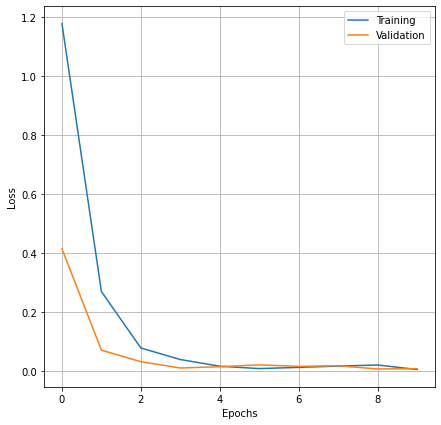

In [25]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("loss_curve.pdf") 
plt.show()



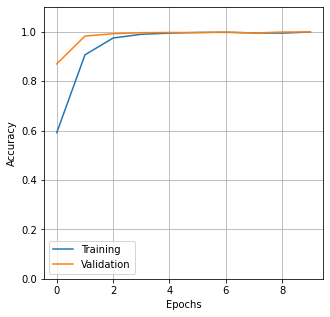

In [26]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("acc_curve.pdf") 
plt.show()

In [27]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [28]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
Xtest.shape

(29944, 25, 25, 15, 1)

In [29]:
ytest=np_utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [30]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      0.99      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      0.99      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [31]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc

In [32]:
import time 
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names=['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [33]:
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

33.27060413360596
936/936 [==============================] - 34s 35ms/step - loss: 0.0046 - accuracy: 0.9991


In [34]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [35]:
X=loadmat('../input/pavia-university-hsi/PaviaU.mat')['paviaU']
y=loadmat('../input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']

In [36]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [37]:
X,pca=applyPCA(X,numComponents=numComponents)


In [38]:
X=padWithZeros(X,PATCH_SIZE//2)


In [39]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

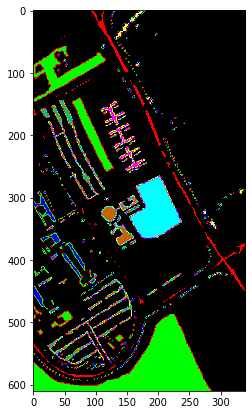

In [40]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))


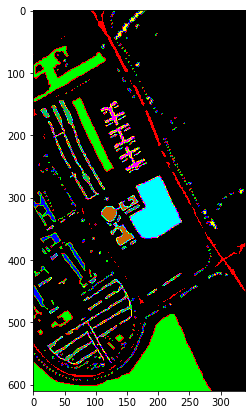

In [41]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [42]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
